In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import time, random
import shap
from scipy.optimize.minpack import leastsq
from diffpy.Structure import Structure, Atom
from diffpy.srfit.pdf import PDFContribution, PDFParser, PDFGenerator
from diffpy.srfit.fitbase import FitRecipe, FitResults, Profile, FitContribution
from diffpy.srreal.pdfcalculator import DebyePDFCalculator
from multiprocessing import Pool
from functools import partial
from ase.io import read
#from google.colab import output, files
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import pandas as pd

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

random.seed(14)
np.random.seed(14)

In [2]:
os.chdir('/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/PDF-Cluster-Prediction/th_clusters/test_th_groups')

In [3]:
def Load_starting_model(starting_model):
    """This function loads the structure"""

    # Read structure and divide it into two lists: Atoms we want to iterate (W) and atoms we do not iterate (O)
    struct=[]
    with open(starting_model, 'r') as fi:
        for line in fi:
            sep_line=line.strip('{}\n\r ').split()
            if len(sep_line)==4: #  tillader andre informationer i xyz filen some ikke skal laeses
                struct.append(sep_line)
    elements=np.array(struct)[:,0]
    xyz=(np.array(struct)[:,1:].astype(float))

    return elements, xyz

def format_XYZ(starting_model, allowed_atoms):
    # Read structure and divide it into two lists: Atoms we want to iterate and atoms we do not iterate.
    # Save the file in this new format and get number of atoms that we iterate.
    permutable_struct = []
    nonpermutable_struct = []
    with open(starting_model, 'r') as fi:
        for line in fi:
            sep_line=line.strip('{}\n\r ').split()
            if len(sep_line)==4: #  tillader andre informationer i xyz filen some ikke skal laeses
            	if sep_line[0] in allowed_atoms:
            		permutable_struct.append(sep_line)
            	else:
            		nonpermutable_struct.append(sep_line)
    struct = permutable_struct + nonpermutable_struct

    with open(starting_model, "w") as New_XYZ:
        New_XYZ.write(str(len(struct)) + "\n\n")
        for i in range(len(struct)):
        	New_XYZ.write(str(struct[i]).replace("[", "").replace("]", "").replace("'", "").replace(",", "") + "\n")
    return len(permutable_struct)
  
def structure_catalogue_maker(Number_of_structures, Number_of_atoms, lower_atom_number, higher_atom_number):
    """This function makes a shuffled list containing 'Number_of_structures' number of lists which each is 
    'Number_of_atoms' long and is randomly distributed with 0's and 1's whereas the minimum number of 1's are 
    'lower_atom_number' and the maximum number of 1's are 'higher_atom_number'."""
    
    print(
        "Starting to make a structure catalogue with: ",
        f"{str(Number_of_structures)} structure from the starting model.",
    )
    print(
        f"The structure will have between {str(lower_atom_number)} and {str(higher_atom_number)} atoms"
    )
    structure_catalogue = []
    for _ in range(Number_of_structures):
        one_count = random.randint(lower_atom_number, higher_atom_number)
        zero_count = Number_of_atoms  - one_count
        my_list = [0]*zero_count + [1]*one_count
        random.shuffle(my_list)
        my_list.insert(0, one_count)
        structure_catalogue.append(my_list)
    print ("Permutations Succeeded")
    return structure_catalogue
    
def fitting(structure_catalogue, atom_ph, Qmin, Qmax, Qdamp, rmin, rmax, plot, index):
    # sourcery skip: low-code-quality
    """This function takes in a 'starting_model', and an 'index' from the 'structure_catalogue'. It generates the 
    corresponding structure and fit it to the 'Experimental_Data'."""
    
    # Read structure and divide it into two lists: Atoms we want to iterate (W) and atoms we do not iterate (O)
    stru = read(starting_model)
    xyz = stru.get_positions()
    xyz_W = xyz[:NumW].copy()
    xyz_O = xyz[NumW:].copy()
    keep_O = np.zeros(len(xyz_O))
    h = 0
    # Cycle through W atoms and delete W according to index 0's from permutation
    permutations = np.asarray(structure_catalogue)[:,1:]
    for j in range(len(xyz_W)):
        if permutations[index][j] == 0:
            xyz_W = np.delete(xyz_W,j - h,0)
            h = h+1
    # Cycle through all atoms that is not iteratable and test if it is within the threshold distance. Delete atoms with no bonds
    for j in range(len(xyz_O)):        
        for k in range(len(xyz_W)):
            dist = np.linalg.norm(xyz_W[k] - xyz_O[j])
            if dist < threshold:    
                keep_O[j] = 1
                break
    h = 0
    for j in range(len(xyz_O)):
        if keep_O[j] == 0:
            xyz_O = np.delete(xyz_O,j - h, 0)
            h += 1

    # Create structure for iterable (W) and non-iterable (O) atoms and combine them
    W_cluster = Structure([Atom('Th', xi) for xi in xyz_W])
    O_cluster = Structure([Atom('O', xi) for xi in xyz_O])
    cluster = W_cluster + O_cluster

    # Make a standard cluster refinement using Diffpy-CMI
    # Import the data and make it a PDFprofile. Define the range of the data that will be used in the fit.
    pdfprofile = Profile()
    pdfparser = PDFParser()
    pdfparser.parseFile(Experimental_Data)
    pdfprofile.loadParsedData(pdfparser)
    pdfprofile.setCalculationRange(xmin = rmin, xmax = rmax)

    # Setup the PDFgenerator that calculates the PDF from the structure
    pdfgenerator_cluster = PDFGenerator("G")
    # Add the profile and both generators to the PDFcontribution
    pdfcontribution = FitContribution("pdf")
    pdfcontribution.setProfile(pdfprofile, xname="r")
    pdfcontribution.addProfileGenerator(pdfgenerator_cluster)

    pdfgenerator_cluster.setQmin(Qmin)
    pdfgenerator_cluster.setQmax(Qmax)
    pdfgenerator_cluster._calc.evaluatortype = 'OPTIMIZED'
    pdfgenerator_cluster.setStructure(cluster, periodic = False)

    # Use scaling factors proportional to molar content
    pdfcontribution.setEquation('mc*G')

    # Define the recipe to do the fit and add it to the PDFcontribution
    recipe = FitRecipe()
    recipe.addContribution(pdfcontribution)

    # Avoid too much output during fitting 
    recipe.clearFitHooks()

    # Add the scale factor.
    recipe.addVar(pdfcontribution.mc, 1.0, tag = "scale", fixed=False)

    # Add the instrumental parameters to the two generators
    pdfgenerator_cluster.qdamp.value = Qdamp

    # Add the delta2 parameters, and make sure it cannot take unphysical values
    recipe.addVar(pdfgenerator_cluster.delta2, 0, name = "delta2_cluster", tag = "delta2")

    # Add ADP and "cell" for the cluster
    phase_cluster = pdfgenerator_cluster.phase
    atoms = phase_cluster.getScatterers()
    lat = phase_cluster.getLattice()

    recipe.newVar("zoomscale1", 1.0, tag = "lat")
    recipe.newVar("zoomscale2", 1.0, tag = "lat")
    recipe.newVar("zoomscale3", 1.0, tag = "lat")
    recipe.constrain(lat.a, 'zoomscale1')
    recipe.constrain(lat.b, 'zoomscale2')
    recipe.constrain(lat.c, 'zoomscale3')

    W_cluster = recipe.newVar("W_Biso_cluster1", 1, tag = 'adp_w')
    O_cluster = recipe.newVar("O_Biso_cluster1", 5, tag = 'adp_o')

    for atom in atoms:
      if atom.element.title() == atom_ph:
            recipe.constrain(atom.Biso, W_cluster)
      elif atom.element.title() == "O":
            recipe.constrain(atom.Biso, O_cluster)

    recipe.restrain("zoomscale1", lb = 0.99, ub = 1.01, sig = 0.001)
    recipe.restrain("zoomscale2", lb = 0.99, ub = 1.01, sig = 0.001)
    recipe.restrain("zoomscale3", lb = 0.99, ub = 1.01, sig = 0.001)

    #free parameters are set
    recipe.fix('all')
    recipe.free("scale", "lat")

    # Turn off printout of iteration number.
    #recipe.clearFitHooks()

    # We can now execute the fit using scipy's least square optimizer.
    leastsq(recipe.residual, recipe.getValues())

    # We calculate the goodness-of-fit, Rwp
    g = recipe.pdf.profile.y
    gcalc = recipe.pdf.evaluate()
    rfactor1 = np.sqrt(sum((g - gcalc)**2) / sum((g)**2))

    # if plot == 1 it will also plot the fit
    if plot == 1:
        print ("FIT RESULTS\n")
        res1 = FitResults(recipe)
        print (res1)

        # Plot the observed and refined PDF.
        # Get the experimental data from the recipe
        r = recipe.pdf.profile.x
        gobs = recipe.pdf.profile.y

        # Get the calculated PDF and compute the difference between the calculated and measured PDF
        gcalc = recipe.pdf.evaluate()
        baseline = 1.1 * gobs.min()
        gdiff = gobs - gcalc

        # Plot!
        plt.figure()
        plt.plot(r, gobs, 'bo', label="G(r) data")
        plt.plot(r, gcalc, 'r-', label="G(r) fit")
        plt.plot(r, gdiff + baseline, 'g-', label="G(r) diff")
        plt.plot(r, np.zeros_like(r) + baseline, 'k:')
        plt.xlabel(r"$r (\AA)$")
        plt.ylabel(r"$G (\AA^{-2})$")
        plt.legend()

        plt.show()
    return rfactor1

def fitting_multiprocess(structure_catalogue, atom_ph, Qmin, Qmax, Qdamp, rmin, rmax, SaveName, cores=1):
    """This function runs the refinement of all the structures in the structure catalogue using multiprocessing"""
    start_time = time.time()
    values = []
    # Set up multiprocessing refinement
    fitindex = range(len(structure_catalogue))
    p = Pool(processes=cores)
    plot = 0
    func = partial(fitting, structure_catalogue, atom_ph, Qmin, Qmax, Qdamp, rmin, rmax, plot)
    results = p.map(func, fitindex)
    p.close()
    p.join()

    # Start refinement and append results to lists
    for i in fitindex:
        if i % 100 == 0:
            print(
                "I have now fitted: ",
                f"{str(i)} structures out of {len(structure_catalogue)}",
            )
        rw = results[i]
        values.extend((i, rw))
    values = np.reshape(values, (len(values) // 2, 2))

    # Save results in format that is suitable for Machine Learning
    print ("Best fit")
    print (values[np.argmin(values[:,1])])
    print("Total execution time: %.3fs" % (time.time()-start_time))
    Result = np.column_stack([values, np.asarray(structure_catalogue)[values[:,0].astype(int)]])
    np.savetxt(SaveName, Result)
    return Result

def Import_Dataset(FileName):
    """This function loads a catalogue of structures with their corresponding Rwp values and split the dataset 
    into a training set and validation set with features and labels."""
    # load data
    dataset = np.loadtxt(FileName, delimiter=" ", skiprows=0)
    dataset_original = dataset.copy()

    # Split into training and validation set
    dataset_train = dataset[:int(len(dataset)*0.8)]
    dataset_val = dataset[int(len(dataset)*0.8):]

    # split data into features (X) and labels (y)
    X_train = dataset_train[:,2:len(dataset)+1]
    y_train = dataset_train[:,1]
    X_val = dataset_val[:,2:len(dataset)+1]
    y_val = dataset_val[:,1]

    print("Number of Training Data:", len(y_train))
    print("Number of Validation Data:", len(y_val))

    return X_train, y_train, X_val, y_val
    
def Validate_XGBoost(model, X_val, y_val):
    """Function to validate the performance of the XGBoost algorithm on a validation set"""
    print ("Giving an estimate of the accuracy of the model")
    xgb_val = xgb.DMatrix(X_val, y_val)
    y_pred_val = model.predict(xgb_val)
    rmse = mean_squared_error(y_val, y_pred_val)
    print("RMSE: %f" % (rmse))
    return rmse

def DecisionTree_CrossValidation(learning_rate, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=0, 
                                       learning_rate = learning_rate,
                                       max_depth=max_depth,
                                       objective='reg:squarederror') 
    
    cval = cross_val_score(estimator, data, targets, cv=3)
    return cval.mean()

def optimize_DecisionTree(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(learning_rate, max_depth):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        accuracy_mean = DecisionTree_CrossValidation(learning_rate = learning_rate,
                                       max_depth=int(max_depth), 
                                       data=data, targets=targets)
        
        return accuracy_mean
    
    optimizer = BayesianOptimization(f=crossval_wrapper, pbounds=pars, 
                                     random_state=0, verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

def train_w_earlyStop(X_train, y_train, learning_rate, max_depth, n_estimators, n_jobs, gamma, min_child_weight, base_score, seed, early_stop, xgb_model=None):
    """Train a XGBoost model using the given parameters. The training will run until the early stop criteria is
    fulfilled or 5000 epochs are run. The loss curve and values is saved."""
    start_time = time.time()

    xgb_params = {
        'learning_rate': learning_rate,
        'objective': 'reg:squarederror',
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'n_jobs': n_jobs,
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'eval_metric': ['mae'],
        'base_score': base_score,
        'seed': seed,
        'verbosity': 0,
    }
    epochs = 5000

    store = {}
    xgb_train = xgb.DMatrix(X_train, y_train)
    xgb_val = xgb.DMatrix(X_val, y_val)
    evallist = [(xgb_train,'train'),(xgb_val, 'val')]
    model = None

    model = xgb.train(xgb_params, xgb_train, epochs, evallist, evals_result=store, verbose_eval=0, early_stopping_rounds=early_stop, xgb_model=model)
    print ("Training using the best parameters")
    print("Total execution time: %.3f s" % (time.time()-start_time))
    print ("Training succeeded")

    # Save Loss
    loss_results = pd.DataFrame(store)
    loss_results.to_csv("LossCurve.csv")

    # Plot Loss
    test_score = store['val']['mae']
    train_score = store['train']['mae']
    plt.plot(range(len(test_score)), test_score, "c", label="Val")
    plt.plot(range(len(train_score)), train_score, "orange", label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("MAE Loss")
    plt.legend()
    plt.savefig("LossCurve.png")
    return model, store

def shap_essential_figure(model, X_train, saveResults):
    """Function that takes a XGBoost model, a training set and calculates SHAP values of each features in the 
    training set. Afterwards, it saves a SHAP summary plot"""
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    # Make SHAP summary plot
    shap.summary_plot(
        shap_values[:, 1:],
        X_train[:, 1:],
        feature_names=[f"Atom #{str(i)}" for i in range(1, X_train.shape[1])],
        color_bar_label="Feature Value (Low: Atom Removed, High: Atom Not Removed)",
        show=False,
        max_display=X_train.shape[1],
    )
    plt.savefig(
        f"{saveResults}SHAP_values.png",
        dpi=600,
        format="png",
        bbox_inches='tight',
    )
    return explainer, shap_values

def calculate_atomContributionValue(shap_values, X_train, saveResults):
    """Calculate atom contribution value list from the result array"""
    
    # Define AtomContributionValues vector
    AtomContributionValues = []
    AtomContributionValues_RMS = []
    for i in range(X_train.shape[1]):
        if i == 0:
            continue
        Keep_atoms = np.mean((shap_values[np.where(X_train[:,i] == 1),i]))
        Keep_atoms_RMS = np.std((shap_values[np.where(X_train[:,i] == 1),i]))
        Remove_atoms = np.mean((shap_values[np.where(X_train[:,i] == 0),i]))
        Remove_atoms_RMS = np.std((shap_values[np.where(X_train[:,i] == 0),i]))
        AtomContributionValues.append(0.5*Keep_atoms - 0.5*Remove_atoms)
        AtomContributionValues_RMS.append(np.sqrt(0.5*Keep_atoms_RMS**2 + 0.5*Remove_atoms_RMS**2))

    for i in range(len(AtomContributionValues_RMS)):
      print ("Atom", i+1," AtomContributionValue: ", AtomContributionValues[i], " +/- ", AtomContributionValues_RMS[i], "Atom", i+1," confidence factor: ", abs(AtomContributionValues[i]/AtomContributionValues_RMS[i]))
    print ("Overall confidence factor: ", np.nanmean(np.abs(np.array(AtomContributionValues)/np.array(AtomContributionValues_RMS))), " +/- ", np.nanstd(np.abs(np.array(AtomContributionValues)/np.array(AtomContributionValues_RMS))))

    # Normalise the AtomContributionValues
    amin, amax = min(AtomContributionValues), max(AtomContributionValues)
    AtomContributionValues = (AtomContributionValues - amin) / (amax - amin)
    AtomContributionValues_ph = sorted(AtomContributionValues)
    # Define colormap of viridis.reverse
    norm = mpl.colors.Normalize(vmin=AtomContributionValues_ph[round((len(AtomContributionValues))/10)], vmax=AtomContributionValues_ph[-round((len(AtomContributionValues))/10)])
    cmap = matplotlib.cm.cividis_r
    m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    # Save results to file
    f = open(f"{saveResults}AtomContributionValues.txt", "w")
    f.write("\nAtom contribution are calculated to: \n")
    for i in range(len(AtomContributionValues)):
        f.write(
            f"Atom # {str(i + 1)}:  {str(AtomContributionValues[i])}  Colorcode:  {mpl.colors.rgb2hex(m.to_rgba(AtomContributionValues[i]))}"
            + "\n"
        )

    return m, AtomContributionValues

def Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, saveResults, threshold):
    # Read bonds and colors of all atoms
    bonding = []
    with open("/Users/dimitrygrebenyuk/Documents/GitHub/ML-MotEx/util/Bonding.txt", 'r') as fi:
        for line in fi:
            sep_line=line.strip('{}\n\r ').split()
            bonding.append(sep_line)
    bonding = np.array(bonding)

    with open(f'{saveResults}_CrystalMaker.cmtx', 'w') as CrystalMaker:
        _extracted_from_Make_CrystalMakerFile_13(
            CrystalMaker,
            "MOLE  CrystalMaker molecule format\n",
            "TITL  Molecule\n\n",
            "! Model type\n",
        )
        _extracted_from_Make_CrystalMakerFile_16(
            CrystalMaker,
            "MODL  1\n\n",
            "! Depth fading settings\n",
            "DCUE  1.000000 0.212899 0.704686\n\n",
        )
        CrystalMaker.write("! Colour definitions:\n")
        CrystalMaker.write("TYPE\n")

            # Assign colors to all the atoms
        for iter, element in enumerate(elements):
            if iter < NumW:
                #CrystalMaker.write(element + str(iter+1) + " 1.32 ")
                CrystalMaker.write(element + str(iter+1) + " " + bonding[np.where(bonding == element)[0][0], 1] + " ")
                rgb1 = m.to_rgba(AtomContributionValues[iter])[:-1][0]
                rgb2 = m.to_rgba(AtomContributionValues[iter])[:-1][1]
                rgb3 = m.to_rgba(AtomContributionValues[iter])[:-1][2]
            else:
                #CrystalMaker.write(element + str(iter+1) + " 0.66 ")
                CrystalMaker.write(element + str(iter+1) + " " + bonding[np.where(bonding == element)[0][0], 1] + " ")
                rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255) #mpl.colors.to_rgb("#FF0000")[0]
                rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255) #mpl.colors.to_rgb("#FF0000")[1]
                rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255) #mpl.colors.to_rgb("#FF0000")[2]
            CrystalMaker.write(f"{str(rgb1)} {str(rgb2)} {str(rgb3)}")
            CrystalMaker.write("\n")
        _extracted_from_Make_CrystalMakerFile_13(
            CrystalMaker, "\n", "! Atoms list\n", "! Bond Specifications\n"
        )
            # Assign bonds between the atoms
        for iter, element in enumerate(elements):
            if iter < NumW:
                NI_elements = np.delete(np.unique(elements), np.where(np.unique(elements) == element)[0])
                for NI_element in NI_elements:
                    CrystalMaker.write(f"BMAX {element} {str(NI_element)}  {str(threshold)}")
                    CrystalMaker.write("\n")

        _extracted_from_Make_CrystalMakerFile_13(
            CrystalMaker, "\n", "! Atoms list\n", "ATOM\n"
        )
            # Assign coordinates to the atoms
        for iter, element in enumerate(elements):
            CrystalMaker.write(
                f"{element} {element}{str(iter + 1)} {str(xyz[iter][0])} {str(xyz[iter][1])} {str(xyz[iter][2])}"
                + "\n"
            )
    return None


# TODO Rename this here and in `Make_CrystalMakerFile`
def _extracted_from_Make_CrystalMakerFile_16(CrystalMaker, arg1, arg2, arg3):
    CrystalMaker.write(arg1)

    CrystalMaker.write(arg2)
    CrystalMaker.write(arg3)


# TODO Rename this here and in `Make_CrystalMakerFile`
def _extracted_from_Make_CrystalMakerFile_13(CrystalMaker, arg1, arg2, arg3):
    _extracted_from_Make_CrystalMakerFile_16(CrystalMaker, arg1, arg2, arg3)

def Make_VestaFile(elements, xyz, AtomContributionValues, m, saveResults, threshold):
    # Read bonds and colors of all atoms
    bonding = []
    with open("/Users/dimitrygrebenyuk/Documents/GitHub/ML-MotEx/util/Bonding.txt", 'r') as fi:
        for line in fi:
            sep_line=line.strip('{}\n\r ').split()
            bonding.append(sep_line)
    bonding = np.array(bonding)

    with open(f'{saveResults}_Vesta.vesta', 'w') as Vesta:
        Vesta.write("#VESTA_FORMAT_VERSION 3.5.4\n\n\n")
        Vesta.write("MOLECULE\n\n")
        Vesta.write("Title\n")
        Vesta.write("XYZ file\n\n")

        Vesta.write("STRUC\n")
            # Assign coordinates to the atoms
        for iter, element in enumerate(elements):
            Vesta.write(
                f"{str(iter + 1)} {element} {element}{str(iter + 1)} 1.0000 {str(xyz[iter][0])} {str(xyz[iter][1])} {str(xyz[iter][2])}1 -"
                + "\n"
            )
            Vesta.write("0 0 0 0\n")
        Vesta.write("  0 0 0 0 0 0 0\n")

        Vesta.write("SBOND\n")
        # Assign bonds between the atoms
        unique_elements = np.unique(elements)
        for iter, element1 in enumerate(unique_elements):
            for iter, element2 in enumerate(unique_elements):
                if element1 != element2:
                    Vesta.write(
                        f"{str(iter + 1)} {element1} {element2} 0.0 {str(threshold)}"
                        + " 0 1 1 0 1 0.25 2 127 127 127\n"
                    )
                    Vesta.write("0 0 0 0\n")

        Vesta.write("SITET\n")
            # Assign colors to all the atoms
        for iter, element in enumerate(elements):
            if iter < NumW:
                rgb1 = int(m.to_rgba(AtomContributionValues[iter])[:-1][0]*255)
                rgb2 = int(m.to_rgba(AtomContributionValues[iter])[:-1][1]*255)
                rgb3 = int(m.to_rgba(AtomContributionValues[iter])[:-1][2]*255)
            else:
                rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255)
                rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255)
                rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255)
            Vesta.write(
                f"{str(iter + 1)} {element}{str(iter + 1)} {bonding[np.where(bonding == element)[0][0], 1]} {rgb1} {rgb2} {rgb3} {rgb1} {rgb2} {rgb3}"
                + " 204 0\n"
            )
        Vesta.write("0 0 0 0 0 0\n")

        Vesta.write("ATOMT\n")
        done_deal_atoms = []
        for iter, element in enumerate(elements):
            if element not in done_deal_atoms:
                rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255)
                rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255)
                rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255)
                Vesta.write(
                    f"{str(iter + 1)} {element} {bonding[np.where(bonding == element)[0][0], 1]} {rgb1} {rgb2} {rgb3} {rgb1} {rgb2} {rgb3}"
                    + " 204\n"
                )
                done_deal_atoms.append(element)
        Vesta.write("0 0 0 0 0 0\n")

    return None


# Step 1: Produce a catalogue of structure motifs
### First define the starting model, how large the structure catalogue has to be, number of iterable atoms and threshold between iterable atoms and non-iterable atoms.

In [9]:
starting_model = 'th40.xyz' # Name of the starting model file
Number_of_structures = 10000 # Number of structures made to the structure catalogue
allowed_atoms = ["Th"] # The atoms that should be permuted, can be multiple atoms
threshold = 3.0 # Threshold for W - O bond
print(starting_model)

th40.xyz


### Produce a catalogue of structure motifs

In [10]:
NumW = format_XYZ(starting_model, allowed_atoms) # Format the starting model and calculate then number of atoms that should be permuted in the starting model
structure_catalogue = structure_catalogue_maker(Number_of_structures, Number_of_atoms=NumW, lower_atom_number=2, higher_atom_number=9)
#print ("We show the first 10 structures in the catalogue:")
#structure_catalogue[:100]

Starting to make a structure catalogue with:  10000 structure from the starting model.
The structure will have between 2 and 9 atoms
Permutations Succeeded


# Step 2: Fit all of the structures from the catalogue of structure motifs to the dataset
### First define the experimental data path and the path you want the structure catalogue with fits to be saved

In [11]:
print ("Upload a PDF file in gr format")
StemName = 'Th22_02_spot1_0001_0000_summed_bsub_tmean_gs2' # Upload PDF from local computer
Experimental_Data = f"{StemName}.grf"
saveFits = f"{StemName}.txt"
atom_ph, Qmin, Qmax, Qdamp, rmin, rmax = "Th", 0.5, 21, 0.02, 1, 15
print(Experimental_Data)


Upload a PDF file in gr format
Th22_02_spot1_0001_0000_summed_bsub_tmean_gs2.grf


In [11]:
os.cpu_count()

8

### Produce organized structure catalogue with Rwp values

In [12]:
Result = fitting_multiprocess(structure_catalogue, atom_ph, Qmin, Qmax, Qdamp, rmin, rmax, SaveName=saveFits, cores=8)
print ("The best fitting structure is:")
Result[np.argmin(Result[:,1])]

I have now fitted:  0 structures out of 10000
I have now fitted:  100 structures out of 10000
I have now fitted:  200 structures out of 10000
I have now fitted:  300 structures out of 10000
I have now fitted:  400 structures out of 10000
I have now fitted:  500 structures out of 10000
I have now fitted:  600 structures out of 10000
I have now fitted:  700 structures out of 10000
I have now fitted:  800 structures out of 10000
I have now fitted:  900 structures out of 10000
I have now fitted:  1000 structures out of 10000
I have now fitted:  1100 structures out of 10000
I have now fitted:  1200 structures out of 10000
I have now fitted:  1300 structures out of 10000
I have now fitted:  1400 structures out of 10000
I have now fitted:  1500 structures out of 10000
I have now fitted:  1600 structures out of 10000
I have now fitted:  1700 structures out of 10000
I have now fitted:  1800 structures out of 10000
I have now fitted:  1900 structures out of 10000
I have now fitted:  2000 structu

array([2.34400000e+03, 5.48872596e-01, 8.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

FIT RESULTS

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       579.72217488
Contributions  555.65930220
Restraints     24.06287268
Chi2           555.65930220
Reduced Chi2   0.39689950
Rw             0.54887262

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
mc          1.46996320e+00 +/- 4.09720249e-02
zoomscale1  1.01341725e+00 +/- 9.71386913e-04
zoomscale2  1.01238169e+00 +/- 9.72380706e-04
zoomscale3  1.01259092e+00 +/- 9.74340808e-04

Fixed Variables
------------------------------------------------------------------------------
O_Biso_cluster1  5.00000000e+00
W_Biso_cluster1  1.00000000e+00
delta2_cluster   0.00000000e+00

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
No correlation

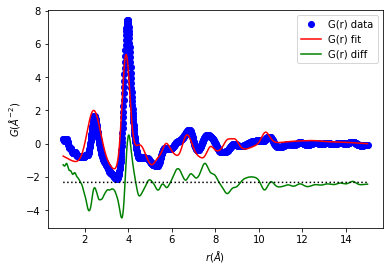

In [13]:
Result = fitting(structure_catalogue, atom_ph, Qmin, Qmax, Qdamp, rmin, rmax, plot=1, index=2344)
#print ("The best fitting structure is:")
#Result[np.argmin(Result[:,1])]

# Step 3: Train a XGBoost Regressor to predict the Rwp value based on the structure catalogue
### Set range for model optimization. 

It can take a few minutes to train the XGBoost model. 
N_iter gives a measure of how rounds the model should try to optimize. Set to a low number for a less accurate but fast convergence. 

Number of Training Data: 8000
Number of Validation Data: 2000
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.914     | 0.4842    | 7.722     |
| 2         | 0.9254    | 0.5219    | 6.359     |
| 3         | 0.9235    | 0.3966    | 7.167     |
| 4         | 0.8936    | 0.4063    | 9.134     |
| 5         | 0.8534    | 0.1288    | 2.007     |
| 6         | 0.9108    | 0.1009    | 5.628     |
| 7         | 0.9314    | 0.8       | 3.64      |
| 8         | 0.8971    | 0.7974    | 2.006     |
| 9         | 0.9369    | 0.797     | 4.829     |
| 10        | 0.9371    | 0.7998    | 4.459     |
| 11        | 0.9153    | 0.7983    | 5.154     |
| 12        | 0.8157    | 0.8       | 10.0      |
| 13        | 0.9007    | 0.1       | 10.0      |
| 14        | 0.8707    | 0.1       | 3.96      |
| 15        | 0.9163    | 0.1       | 8.194     |
| 16        | 0.8961    | 0.8       | 2.78      |
| 17        | 0.9212    | 0.1003    | 

Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


Training using the best parameters
Total execution time: 9.868 s
Training succeeded
Giving an estimate of the accuracy of the model
RMSE: 0.000448


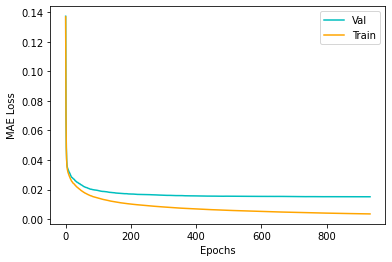

In [25]:
Min_LR = 0.1 # Minimum learning rate for the XGBoost algorithm
Max_LR = 0.8 # Maximum learning rate for the XGBoost algorithm
Min_Dep = 2 # Minimum max depth for the XGBoost algorithm
Max_Dep = 10 # Maximum max depth for the XGBoost algorithm
n_iter = 50 # Number of iterations for the bayesian optimization model

# Import dataset
StemName = 'Th22_03_spot1_0001_0000_summed_bsub_tmean_gs2'
saveFits = f"{StemName}.txt"
X_train, y_train, X_val, y_val = Import_Dataset(saveFits)

# Make a dictionary of parameters we should optimize for the ML algorithm
parameters_BayesianOptimization = {"learning_rate": (Min_LR, Max_LR), #0.1 is default - Boosting learning rate
                                   "max_depth": (Min_Dep, Max_Dep)}  #3 is default - Maximum tree depth for base learners.

# Finding the best parameters for the ML model
BayesianOptimization_func = optimize_DecisionTree(X_train, y_train, parameters_BayesianOptimization, n_iter=n_iter)
print("Best parameters were: ", BayesianOptimization_func.max)


# Get best parameters for the ML model and make max depth to an integer
params = BayesianOptimization_func.max['params']
params['max_depth'] = int(params['max_depth'])

#  Define model, train and validate the model and save model
model, store = train_w_earlyStop(X_train, y_train, n_jobs=1, seed=0, base_score=0.5, n_estimators=100, gamma=0, min_child_weight=1, early_stop=50, **params)
Validate_XGBoost(model, X_val, y_val)
model.save_model(f"{StemName}_XGB_model.dat")


# Step 4: Calculate atom contribution values



Atom 1  AtomContributionValue:  0.004921025363728404  +/-  0.003525942604907063 Atom 1  confidence factor:  1.3956623561823727
Atom 2  AtomContributionValue:  -0.005541308200918138  +/-  0.00509309293929656 Atom 2  confidence factor:  1.0880045322093579
Atom 3  AtomContributionValue:  0.0005626325582852587  +/-  0.004691991743395575 Atom 3  confidence factor:  0.1199133734788041
Atom 4  AtomContributionValue:  -0.019344881642609835  +/-  0.007233790734130992 Atom 4  confidence factor:  2.6742384945330837
Atom 5  AtomContributionValue:  -0.016960603184998035  +/-  0.006939631716181005 Atom 5  confidence factor:  2.444020645281698
Atom 6  AtomContributionValue:  0.004597766906954348  +/-  0.00402145067899047 Atom 6  confidence factor:  1.143310529947505
Atom 7  AtomContributionValue:  -0.01906338706612587  +/-  0.00750005308017351 Atom 7  confidence factor:  2.54176695315933
Atom 8  AtomContributionValue:  0.004381022998131812  +/-  0.003492804143935989 Atom 8  confidence factor:  1.2542

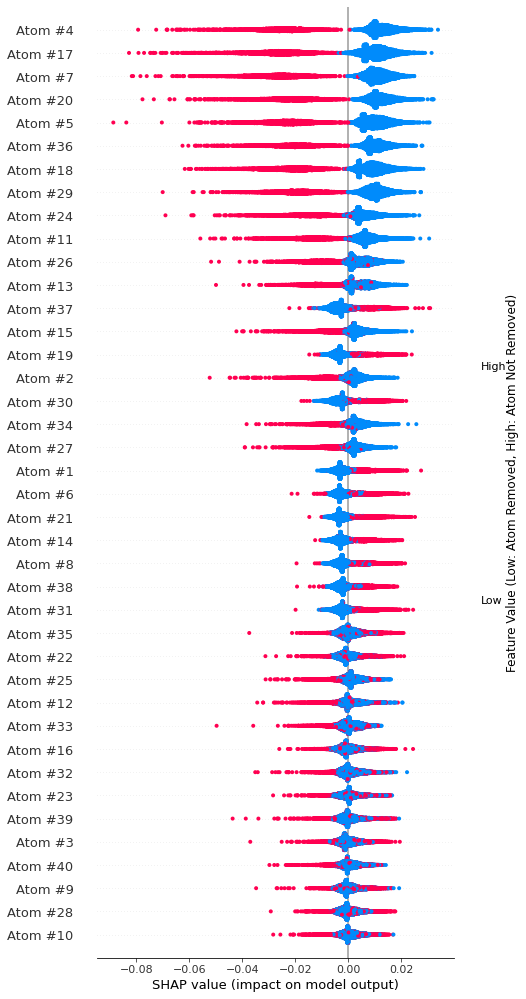

In [26]:
# Calculate SHAP values and save to savePATH.
explainer, shap_values = shap_essential_figure(model, X_train, "./")

# Calculate atom contribution values
m, AtomContributionValues = calculate_atomContributionValue(shap_values, X_train, "./")

# Output a CrystalMaker and VESTA file
elements, xyz = Load_starting_model(starting_model)
Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, StemName, threshold)
Make_VestaFile(elements, xyz, AtomContributionValues, m, StemName, threshold)

# Custom functions

In [20]:
import os
import numpy as np


def catalogue_to_arrays(catalogue, number_of_best_structures):
    '''This function reads the prepared catalogue of structures and returns
    only user-provided number of best structures based on Rw value of the PDF fits.'''
    with open(catalogue, 'r') as f:
        strings = f.readlines()
    filtered_strings = [s for s in strings if float(s.split()[1]) <= 0.95]
    sorted_strings = sorted(filtered_strings, key=lambda x: float(x.split()[1]))
    arrays = []
    for s in sorted_strings:
        # Split the string into a list of numbers
        numbers = list(map(float, s.split()))
        arrays.append(np.array(numbers))
    return arrays[:number_of_best_structures]


def modify_xyz_files(arrays, xyz_filename, new_dir):
    '''This function takes the selected best structures and the initial xyz file with the starting model
    and creates a series of xyz files with those best structures.'''
    # Create the new directory if it doesn't exist
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    # Open the input xyz file
    with open(xyz_filename, 'r') as f:
        lines = f.readlines()

    # Get the number of atoms from the xyz file
    num_atoms = int(lines[0])

    # Iterate over the arrays
    for array in arrays:
        # Create a list to store the modified xyz lines
        new_lines = []

        # Append the header to the new lines list
        new_lines.append(f"{num_atoms}\n")
        new_lines.append(lines[1])

        # Iterate over the atoms in the xyz file
        for i, line in enumerate(lines[2:]):
            # If the index is less than the length of the array, process the atom according to the array value
            if i < len(array):
                if array[i] == 1:
                    new_lines.append(line)
            # If the index is greater than or equal to the length of the array, retain the atom
            else:
                new_lines.append(line)

        # Compute the new xyz filename using the first two values of the initial array
        new_filename = "{:.2f}_{:.0f}.xyz".format(array[1], array[0])

        # Join the new directory and the new filename
        new_path = os.path.join(new_dir, new_filename)

        # Write the modified xyz file
        with open(new_path, 'w') as f:
            f.writelines(new_lines)

def filter_atoms(path, new_directory, threshold_distance):
    '''This function takes the xyz files created on a previous step and deletes
    all non-bonded atoms based on the user-provided treshold value.'''
    # Create new directory if it doesn't exist
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    
    with open(path, 'r') as f:
        lines = f.readlines()
        # Prepare new filename and write the new file
        new_filename = f"{path.split('/')[-1]}"
        new_file = os.path.join(new_directory, new_filename)
        with open(new_file, 'w') as new_f:
            # write the header
            new_f.write(lines[0])
            new_f.write(lines[1])
            # Create a list to store the Th coordinates
            Th_coordinates = []
            for line in lines[2:]:
                fields = line.split()
                if fields and fields[0] == "Th":
                    new_f.write(line)
                    Th_coordinates.append([float(fields[1]), float(fields[2]), float(fields[3])])
                elif fields and fields[0] == "O":
                    O_coordinate = [float(fields[1]), float(fields[2]), float(fields[3])]
                    for Th_coordinate in Th_coordinates:
                        distance = np.linalg.norm(np.array(Th_coordinate) - np.array(O_coordinate))
                        if distance < threshold_distance:
                            new_f.write(line)
                            break

In [23]:
arrays = catalogue_to_arrays('Th22_03_spot1_0001_0000_summed_bsub_tmean_gs2.txt', 5)
modify_xyz_files(arrays, 'th40.xyz', '/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/ThO2/fits/dataset_03/ML/catalogue_best')

In [24]:
directory = '/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/ThO2/fits/dataset_03/ML/catalogue_best'
new_directory = '/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/ThO2/fits/dataset_03/ML/catalogue_best/filtered'
threshold_distance = 3.0

for filename in os.listdir(directory):
    if filename.endswith(".xyz"):
        path = os.path.join(directory, filename)
        filter_atoms(path, new_directory, threshold_distance)